<a href="https://colab.research.google.com/github/nanopiero/fusion_2d_od/blob/main/notebooks/build_fusion_2d_of_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/nanopiero/fusion_2d_od.git

Cloning into 'fusion_2d_od'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 63 (delta 36), reused 18 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 3.01 MiB | 11.77 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
# Construction d'un problème de fusion avec des données opportunes.
# on va aborder ça avec des pluvios "en mode netatmo"

# 1. Je me place sur une carte où j'ai une densité de 4 pluvios de réf bien répartis par imagette
# + 40 pluvios d'opportunité par imagette
# une imagette = 64 x 64 = 4096 pixels.
# -> p = 0.001 pour un pluvio de réf et p = 0.01 pour pluvio d'opportunité
# sur la carte répartition homogène de 1000 pluvios
# à raison d'un pluvio  tous les 1000 pixels -> sur une carte de 1000 x 1000 pixels



import torch
import numpy as np

def poisson_disk_sampling(width, height, r, N_max=5000):
    """
    Poisson disk sampling using Bridson's algorithm.
    """
    k = 30  # Number of attempts
    cell_size = r / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -torch.ones((grid_w, grid_h), dtype=torch.int64)
    points = []

    def in_bounds(p):
        return 0 <= p[0] < width and 0 <= p[1] < height

    def in_neighborhood(p):
        i, j = int(p[0] // cell_size), int(p[1] // cell_size)
        for di in range(-2, 3):
            for dj in range(-2, 3):
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_w and 0 <= nj < grid_h and grid[ni, nj] != -1:
                    neighbor = points[grid[ni, nj]]
                    if torch.norm(torch.tensor(p) - torch.tensor(neighbor)) < r:
                        return True
        return False

    p0 = (torch.randint(0, width, (1,)).item(), torch.randint(0, height, (1,)).item())
    points.append(p0)
    grid[int(p0[0] // cell_size), int(p0[1] // cell_size)] = 0
    active = [p0]

    while active and len(points) < N_max:
        idx = torch.randint(0, len(active), (1,)).item()
        p = active[idx]
        found = False
        for _ in range(k):
            angle = 2 * np.pi * torch.rand(1).item()
            radius = r * (1 + torch.rand(1).item())
            new_p = (p[0] + radius * np.cos(angle), p[1] + radius * np.sin(angle))
            if in_bounds(new_p) and not in_neighborhood(new_p):
                points.append(new_p)
                grid[int(new_p[0] // cell_size), int(new_p[1] // cell_size)] = len(points) - 1
                active.append(new_p)
                found = True
                break
        if not found:
            active.pop(idx)

    return torch.tensor(points, dtype=torch.int64)

def sample_gauge_positions(N, mode='uniform', dist_min=10, density_cluster_centers=0.001):
    width, height = 1000, 1000

    if mode == 'uniform':
        positions = torch.randint(0, width, (N, 2))

    elif mode == 'regular':
        points = poisson_disk_sampling(width, height, dist_min, N_max=N)
        positions = points[torch.randperm(len(points))[:N]] if len(points) > N else points

    elif mode == 'concentrated':
        num_clusters = int(width * height * density_cluster_centers)
        cluster_centers = torch.randint(0, width, (num_clusters, 2))
        positions = []

        for center in cluster_centers:
            num_points = max(1, N // num_clusters)
            cluster_points = center + torch.randint(-20, 20, (num_points, 2))
            cluster_points = cluster_points.clamp(0, width - 1)
            positions.append(cluster_points)

        positions = torch.cat(positions, dim=0)[:N]

    else:
        raise ValueError("Invalid mode. Choose from 'uniform', 'regular', or 'concentrated'.")

    return positions


In [5]:
torch.manual_seed(0)
ref_gauge_positions = sample_gauge_positions(1000, mode='regular', dist_min=25)
ref_gauge_positions = ref_gauge_positions[torch.randperm(1000),:]
good_ref_gauge_positions = ref_gauge_positions[:950]
bad_ref_gauge_positions = ref_gauge_positions[950:]

other_opp_gauge_positions = sample_gauge_positions(10000, mode='concentrated',density_cluster_centers=0.002)
other_opp_gauge_positions = other_opp_gauge_positions[torch.randperm(10000),:]
asref_opp_gauge_positions = other_opp_gauge_positions[:2000]
clogged_opp_gauge_positions = other_opp_gauge_positions[2000:4000]
foolish_opp_gauge_positions = other_opp_gauge_positions[4000:6000]
rnr_opp_gauge_positions = other_opp_gauge_positions[6000:8000]
overestimation_opp_gauge_positions = other_opp_gauge_positions[8000:9000]
underestimation_opp_gauge_positions = other_opp_gauge_positions[9000:]

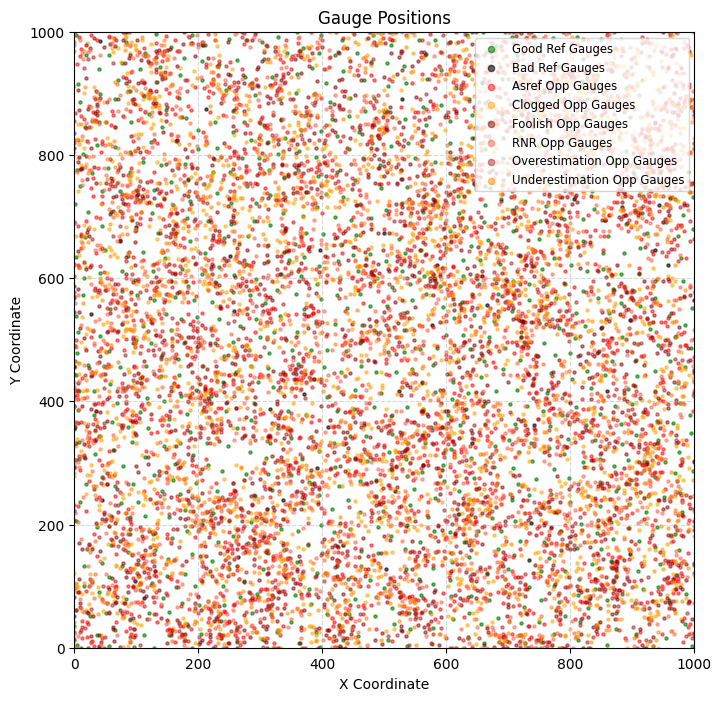

In [6]:
# Re-import necessary libraries since the execution state was reset
import torch
import matplotlib.pyplot as plt

def plot_categorized_positions(
    good_ref, bad_ref, asref_opp, clogged_opp, foolish_opp, rnr_opp, overestimation_opp, underestimation_opp
):
    width, height = 1000, 1000

    plt.figure(figsize=(8, 8))
    plt.xlim(0, width)
    plt.ylim(0, height)
    size = 5
    # Plot reference gauges
    plt.scatter(good_ref[:, 0], good_ref[:, 1], s=size, alpha=0.6, c='green', label="Good Ref Gauges")
    plt.scatter(bad_ref[:, 0], bad_ref[:, 1], s=size, alpha=0.6, c='black', label="Bad Ref Gauges")

    # Plot opportunistic gauges in warm colors
    plt.scatter(asref_opp[:, 0], asref_opp[:, 1], s=size, alpha=0.5, c='red', label="Asref Opp Gauges")
    plt.scatter(clogged_opp[:, 0], clogged_opp[:, 1], s=size, alpha=0.5, c='orange', label="Clogged Opp Gauges")
    plt.scatter(foolish_opp[:, 0], foolish_opp[:, 1], s=size, alpha=0.5, c='darkred', label="Foolish Opp Gauges")
    plt.scatter(rnr_opp[:, 0], rnr_opp[:, 1], s=size, alpha=0.5, c='tomato', label="RNR Opp Gauges")
    plt.scatter(overestimation_opp[:, 0], overestimation_opp[:, 1], s=size, alpha=0.5, c='firebrick', label="Overestimation Opp Gauges")
    plt.scatter(underestimation_opp[:, 0], underestimation_opp[:, 1], s=size, alpha=0.5, c='darkorange', label="Underestimation Opp Gauges")

    plt.title("Gauge Positions")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc="upper right", fontsize="small", markerscale=2.)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


# Plot the categorized gauge positions
plot_categorized_positions(
    good_ref_gauge_positions, bad_ref_gauge_positions,
    asref_opp_gauge_positions, clogged_opp_gauge_positions,
    foolish_opp_gauge_positions, rnr_opp_gauge_positions,
    overestimation_opp_gauge_positions, underestimation_opp_gauge_positions
)


In [8]:
# Assign class labels
good_ref_labels = torch.full((good_ref_gauge_positions.shape[0], 1), 0, dtype=torch.int64)
bad_ref_labels = torch.full((bad_ref_gauge_positions.shape[0], 1), 1, dtype=torch.int64)
asref_opp_labels = torch.full((asref_opp_gauge_positions.shape[0], 1), 2, dtype=torch.int64)
clogged_opp_labels = torch.full((clogged_opp_gauge_positions.shape[0], 1), 3, dtype=torch.int64)
foolish_opp_labels = torch.full((foolish_opp_gauge_positions.shape[0], 1), 4, dtype=torch.int64)
rnr_opp_labels = torch.full((rnr_opp_gauge_positions.shape[0], 1), 5, dtype=torch.int64)
overestimation_opp_labels = torch.full((overestimation_opp_gauge_positions.shape[0], 1), 6, dtype=torch.int64)
underestimation_opp_labels = torch.full((underestimation_opp_gauge_positions.shape[0], 1), 7, dtype=torch.int64)

# Concatenate positions with their respective labels
good_ref_data = torch.cat((good_ref_gauge_positions, good_ref_labels), dim=1)
bad_ref_data = torch.cat((bad_ref_gauge_positions, bad_ref_labels), dim=1)
asref_opp_data = torch.cat((asref_opp_gauge_positions, asref_opp_labels), dim=1)
clogged_opp_data = torch.cat((clogged_opp_gauge_positions, clogged_opp_labels), dim=1)
foolish_opp_data = torch.cat((foolish_opp_gauge_positions, foolish_opp_labels), dim=1)
rnr_opp_data = torch.cat((rnr_opp_gauge_positions, rnr_opp_labels), dim=1)
overestimation_opp_data = torch.cat((overestimation_opp_gauge_positions, overestimation_opp_labels), dim=1)
underestimation_opp_data = torch.cat((underestimation_opp_gauge_positions, underestimation_opp_labels), dim=1)

# Combine all into a single tensor
all_gauge_data = torch.cat(
    (good_ref_data, bad_ref_data, asref_opp_data, clogged_opp_data,
     foolish_opp_data, rnr_opp_data, overestimation_opp_data, underestimation_opp_data), dim=0
)

print(all_gauge_data.shape)

torch.Size([11000, 3])


In [9]:
import torch

# Define the threshold distance (integer sqrt(2 * 40^2))
radius = int((2*(32**2)) ** 0.5)

# Compute pairwise squared distances using broadcasting
coords = all_gauge_data[:, :2]  # Extract x, y positions only
diffs = coords.unsqueeze(1) - coords.unsqueeze(0)  # Compute (x_i - x_j), (y_i - y_j) for all pairs
dists_sq = (diffs ** 2).sum(dim=2)  # Compute squared Euclidean distance

# Find indices where distance is within threshold
within_range = dists_sq <= radius ** 2  # Boolean mask

# Create the neighborhood dictionary with k as the first element
nd = {}
for i in range(coords.shape[0]):
    neighbors = torch.where(within_range[i])[0].tolist()  # Get all neighbors
    if i in neighbors:
        neighbors.remove(i)  # Remove i if it's not at the first place
    else:
      raise()
    neighbors.insert(0, i)  # Ensure i is at the first position
    nd[i] = neighbors  # Store the reordered list

# Print a small sample of the neighborhood dictionary
sample_nd = {k: nd[k] for k in list(nd.keys())[:10]}
print(sample_nd)

{0: [0, 172, 186, 613, 674, 987, 1084, 1264, 1270, 1287, 1296, 1358, 1440, 1566, 1842, 1884, 1916, 2055, 2108, 2151, 2225, 2351, 2604, 2645, 2667, 2801, 2802, 3116, 3121, 3441, 3523, 3575, 3743, 3744, 3779, 3785, 3818, 3830, 4079, 4084, 4508, 4941, 4982, 5078, 5097, 5104, 5252, 5268, 5276, 5488, 5540, 5548, 5743, 5947, 6016, 6098, 6365, 6375, 6426, 6482, 6551, 6667, 6681, 6704, 6749, 6783, 6848, 6860, 6921, 7442, 7497, 7499, 7735, 7885, 7970, 8039, 8074, 8127, 8165, 8184, 8520, 8597, 8624, 8694, 8862, 8925, 9272, 9306, 9333, 9355, 9393, 9447, 9449, 9683, 9826, 9962, 10135, 10432, 10439, 10684, 10740, 10846, 10850, 10914], 1: [1, 227, 231, 374, 754, 936, 940, 1481, 1638, 2012, 2164, 2304, 2430, 2443, 2577, 2959, 3024, 3531, 3544, 3581, 3760, 3900, 3974, 3990, 4105, 4411, 4552, 5229, 5589, 5635, 5657, 5883, 5903, 5919, 6006, 6023, 6443, 7053, 7252, 7699, 7851, 8045, 8102, 8721, 8815, 8922, 8964, 9002, 9049, 9308, 9404, 9538, 9583, 9714, 9726, 10043, 10090, 10218, 10281], 2: [2, 68, 496, 

In [10]:
neighborhood_sizes = torch.tensor([len(v) for v in nd.values()])
max_len = neighborhood_sizes.max().item()  # Maximum list length
min_len = neighborhood_sizes.min().item()  # Minimum list length
mean_len = neighborhood_sizes.float().mean().item()  # Mean length
quantiles = torch.quantile(neighborhood_sizes.float(), torch.tensor([0.25, 0.5, 0.75])).tolist()  # Q1, median, Q3
print(f"Max length: {max_len}")
print(f"Min length: {min_len}")
print(f"Mean length: {mean_len:.2f}")
print(f"Q1 (25%): {quantiles[0]:.2f}")
print(f"Median (50%): {quantiles[1]:.2f}")
print(f"Q3 (75%): {quantiles[2]:.2f}")


Max length: 124
Min length: 17
Mean length: 71.41
Q1 (25%): 60.00
Median (50%): 71.00
Q3 (75%): 83.00


-> 350 gauges as inputs

In [11]:
nd_stacked = {i: torch.tensor(neighbors, dtype=torch.int64) for i, neighbors in nd.items()}

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from fusion_2d_od.utile_denoising import gen

class GaugeDataset(Dataset):
    def __init__(self, gauge_data, nd_stacked):
        self.gauge_data = gauge_data
        self.nd_stacked = nd_stacked
        self.image_size = 64
        self.center_shift = torch.tensor([32, 32], dtype=torch.long)
        self.limit_len = 100

    def __len__(self):
        return len(self.gauge_data)

    def __getitem__(self, idx):
        # Select neighbors
        gauges = self.nd_stacked[idx]
        gauges = self.gauge_data[gauges]
        # Apply centering with random shift
        shift = gauges[0, :2] + 0*torch.randint(-4, 5, (2,))
        gauges[:, :2] -= shift
        # Apply random rotation
        theta = torch.rand(1) * 2 * torch.pi

        rotation_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                        [torch.sin(theta), torch.cos(theta)]], dtype=torch.float32)
        gauges[:, :2] = torch.mm(gauges[:, :2].float(), rotation_matrix).long()

        # Shift to center of picturlet
        gauges[:, :2] += self.center_shift
        # Prune out of bounds
        mask = ((gauges[:, 0] >= 0) & (gauges[:, 0] < self.image_size) &
                (gauges[:, 1] >= 0) & (gauges[:, 1] < self.image_size))
        gauges = gauges[mask]

        gauges = gauges[torch.randperm(gauges.shape[0]),:]
        ground_truth, _ = gen(1)
        ground_truth = ground_truth.squeeze(0).squeeze(0)

        # perfect gauges
        gauges[:,2] = 0
        gauges = self.sample_ground_truth(gauges, ground_truth)

        # Ensure tensor is collatable
        gauges = self.limit_gauge_tensor(gauges)
        return gauges, ground_truth


    def sample_ground_truth(self, gauges, ground_truth):
        # Sample ground truth values at gauge positions
        x_indices = gauges[:, 0].long().clamp(0, self.image_size - 1)
        y_indices = gauges[:, 1].long().clamp(0, self.image_size - 1)
        rain_rates = ground_truth[x_indices, y_indices]

        # Modify based on gauge class
        classes = gauges[:, 2].long()

        rain_rates[classes == 1] = 0  # Bad ref
        rain_rates[classes == 3] = 0  # Clogged
        rain_rates[classes == 4] = ground_truth[torch.randint(0, self.image_size, (1,)),
                                                torch.randint(0, self.image_size, (1,))]  # Foolish
        rain_rates[classes == 5] *= torch.rand((rain_rates[classes == 5].shape[0],), dtype=torch.float32) * 4.9 + 0.1  # RNR
        rain_rates[classes == 6] *= 2  # Overestimation
        rain_rates[classes == 7] /= 2  # Underestimation

        # Append rain rate as the fourth column
        gauges = torch.cat((gauges, rain_rates.unsqueeze(1)), dim=1)
        return gauges

    def limit_gauge_tensor(self, gauges):
        num_gauges = gauges.shape[0]

        if num_gauges > self.limit_len:
            gauges = gauges[:self.limit_len]
        elif num_gauges < self.limit_len:
            deficit = self.limit_len - num_gauges
            padding = torch.tensor([[-1, -1, -1, -0.1]] * deficit, dtype=torch.float32)
            gauges = torch.cat((gauges, padding), dim=0)
            gauges = gauges[torch.randperm(gauges.shape[0]),:]
        return gauges

# Instantiate dataset
gauge_dataset = GaugeDataset(all_gauge_data, nd_stacked)



In [17]:
gauge_loader = DataLoader(gauge_dataset, batch_size=64, shuffle=True, num_workers=2)
it = iter(gauge_loader)

In [18]:
%%timeit -r 1 -n 1
for i, a in enumerate(gauge_loader):
  if i%100 == 0:
    print(i)

0
100
27.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


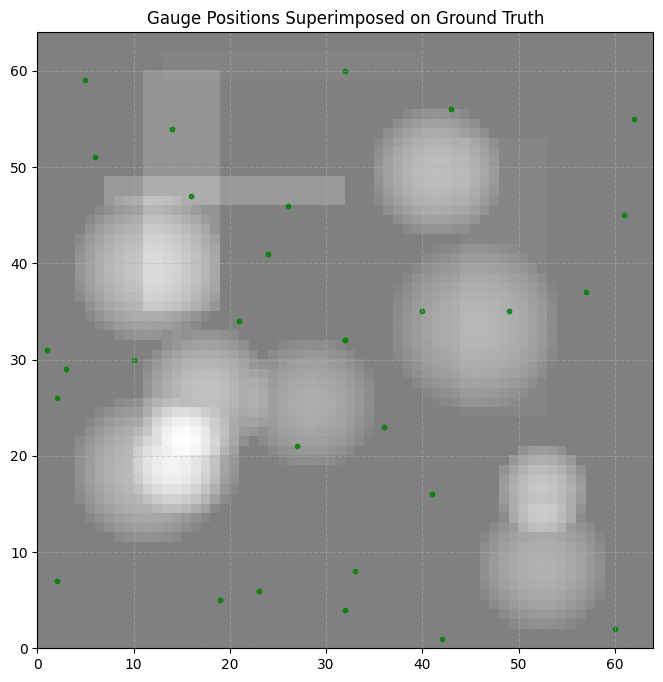

In [19]:
# Iterate dataset and visualize
plt.figure(figsize=(8, 8))
colors = {0: 'green', 1: 'black', 2: 'red', 3: 'orange', 4: 'darkred', 5: 'tomato', 6: 'firebrick', 7: 'darkorange'}


gauges, ground_truth = next(it)

# Display ground truth as dimmed background
plt.imshow(ground_truth[0].numpy(), cmap='gray', alpha=0.5, extent=[0, 64, 0, 64])

# Scatter plot of gauges
for gauge in gauges:
    x, y, cls = gauge[0].tolist()[:3]
    plt.scatter(x, y, s=10, alpha=0.8, c=colors.get(int(cls), 'gray'))

plt.xlim(0, 64)
plt.ylim(0, 64)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Gauge Positions Superimposed on Ground Truth")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class TinyTransformer(nn.Module):
    def __init__(self, num_classes=8, d_model=32, nhead=4, num_layers=6):
        super(TinyTransformer, self).__init__()
        self.d_model = d_model

        # Positional Encoding for (x, y) coordinates
        self.pos_embedding = nn.Linear(2, d_model // 2)

        # Class + Value Embedding
        self.class_embedding = nn.Embedding(num_classes, d_model // 4)
        self.value_embedding = nn.Linear(1, d_model // 4)

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=64, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output layer (probability of class + rain rate value)
        self.fc_out = nn.Linear(d_model, 2)

    def forward(self, x):
        pos_emb = self.pos_embedding(x[:, :, :2])

        # Mask to ignore class -1
        valid_mask = x[:, :, 2] >= 0

        # Initialize class embedding tensor
        class_emb = torch.zeros(x.shape[0], x.shape[1], self.class_embedding.embedding_dim, device=x.device)

        # Apply class embedding only where class is valid
        valid_classes = x[:, :, 2].long().clamp(0, self.class_embedding.num_embeddings - 1)
        class_emb[valid_mask] = self.class_embedding(valid_classes[valid_mask])

        value_emb = self.value_embedding(x[:, :, 3].unsqueeze(-1))

        # Concatenate embeddings
        x_emb = torch.cat([pos_emb, class_emb, value_emb], dim=-1)

        # Pass through transformer
        x_transformed = self.transformer(x_emb)

        # Output prediction
        output = self.fc_out(x_transformed)
        return output



# Function to partition gauges

def part_gauges(xy, eval=False):
    bs, num_points, _ = xy.shape
    device = xy.device

    # Generate random Ki values for each batch element
    Ki_values = torch.randint(10, 90, (bs,), device=device)

    # Create a batch-wise mask (bs x num_points)
    random_indices = torch.rand(bs, num_points, device=device).argsort(dim=1)  # Shuffle points
    mask = torch.arange(num_points, device=device).expand(bs, num_points) < Ki_values.unsqueeze(1)  # Create boolean mask
    mask = torch.gather(mask, dim=1, index=random_indices)  # Apply random permutation

    # Clone xy to form x and y
    x, y = xy.clone(), xy.clone()

    # Apply mask to set values to -0.1 (apply to the last dimension only)
    x[:, :, 3][~mask] = -0.1  # Mask target values in x (inputs)
    # y[:, :, 3][mask] = -0.1  # Mask input values in y (targets)
    if eval == True:
      x = y
    return x, y

# Training loop
def train_transformer(model, dataloader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss(reduction='none')  # MAE

    for epoch in range(num_epochs):
        model.train()
        total_loss, count = 0, 0

        for k, batch in enumerate(dataloader):
            if k % 100 == 0:
              print(k)
            gauges, _ = batch
            gauges = gauges.to(device)
            x, y = part_gauges(gauges)
            x, y = x.to(device), y.to(device)
            x[:,:2] = 1./64 * x[:,:2]
            optimizer.zero_grad()

            pred = model(x)
            mask = (y[:, :, 3] != -0.1).float()
            loss = loss_fn(pred[:, :, 1], y[:, :, 3]) * mask
            loss = loss.sum() / mask.sum()  # Masked MAE

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1

        print(f"Epoch {epoch + 1}, MAE: {total_loss / count:.4f}")

# Create model and loader
tiny_transformer = TinyTransformer()
gauge_loader = DataLoader(gauge_dataset, batch_size=32, shuffle=True, num_workers=4)




/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [23]:
# Train model
train_transformer(tiny_transformer, gauge_loader, num_epochs=10)

0
100
200
300
Epoch 1, MAE: 0.1273
0
100
200
300
Epoch 2, MAE: 0.1069
0
100
200
300
Epoch 3, MAE: 0.1028
0
100
200
300
Epoch 4, MAE: 0.1017
0
100
200
300
Epoch 5, MAE: 0.1002
0
100
200
300
Epoch 6, MAE: 0.0995
0
100
200
300
Epoch 7, MAE: 0.0993
0
100
200
300
Epoch 8, MAE: 0.0983
0


KeyboardInterrupt: 

## B. Traitement par FCN

In [ ]:
ground_truth.shape

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np


def project_to_grid(x, y):
    bs, num_points, _ = x.shape
    device = x.device

    # Initialize tensors with -0.1
    proj_x = torch.full((bs, 2, 64, 64), -0.1, device=device)
    proj_y = torch.full((bs, 1, 64, 64), -0.1, device=device)

    # Get valid indices for x
    valid_mask_x = (x[:, :, :3] != -1).all(dim=2)
    batch_idx_x = torch.arange(bs, device=device).unsqueeze(1).expand(bs, num_points)[valid_mask_x]
    indices_x = x[:, :, :2].long()[valid_mask_x]

    # Fill proj_x using advanced indexing
    proj_x[batch_idx_x, 0, indices_x[:, 0], indices_x[:, 1]] = x[:, :, 2][valid_mask_x]  # Class info
    proj_x[batch_idx_x, 1, indices_x[:, 0], indices_x[:, 1]] = x[:, :, 3][valid_mask_x]  # Input values

    # Get valid indices for y
    valid_mask_y = (y[:, :, 3] != -0.1)
    batch_idx_y = torch.arange(bs, device=device).unsqueeze(1).expand(bs, num_points)[valid_mask_y]
    indices_y = y[:, :, :2].long()[valid_mask_y]

    # Fill proj_y using advanced indexing
    proj_y[batch_idx_y, 0, indices_y[:, 0], indices_y[:, 1]] = y[:, :, 3][valid_mask_y]

    return proj_x, proj_y



# Loss function
def masked_mae_loss(pred, target):
    mask = target != -0.1
    loss = torch.abs(pred - target)[mask]
    return loss.mean()

# Visualization function
def visualize_unet_output(model, dataloader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for batch in dataloader:
            gauges, ground_truth = batch

            gauges = gauges.to(device)
            x, y = part_gauges(gauges)
            x, y = x.to(device), y.to(device)

            proj_x, proj_y = project_to_grid(x, y)
            proj_x[:,1] /= 10.
            pred = model(proj_x)

            # Convert to numpy for visualization
            proj_x = proj_x.cpu().numpy()[0, 1]  # Input values
            proj_y = proj_y.cpu().numpy()[0, 0]  # Target values
            pred = pred.cpu().numpy()[0, 0]  # Predictions

            # Plot results
            fig, ax = plt.subplots(1, 4, figsize=(15, 5))
            ax[0].imshow(proj_x, cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[0].set_title("Input Field")
            ax[1].imshow(proj_y, cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[1].set_title("Target Field")
            ax[2].imshow(pred, cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[2].set_title("Predicted Field")
            ax[3].imshow(ground_truth.cpu().numpy()[0], cmap='jet', vmin=-0.1, vmax = 0.5)
            ax[3].set_title("Predicted Field")
            plt.show()
            print(proj_x.shape, ground_truth.shape)
            print(proj_x[proj_x>= 0], ground_truth[0][proj_x>= 0] )
            break  # Visualize only one batch
    return gauges, ground_truth, x, y, proj_x, proj_y




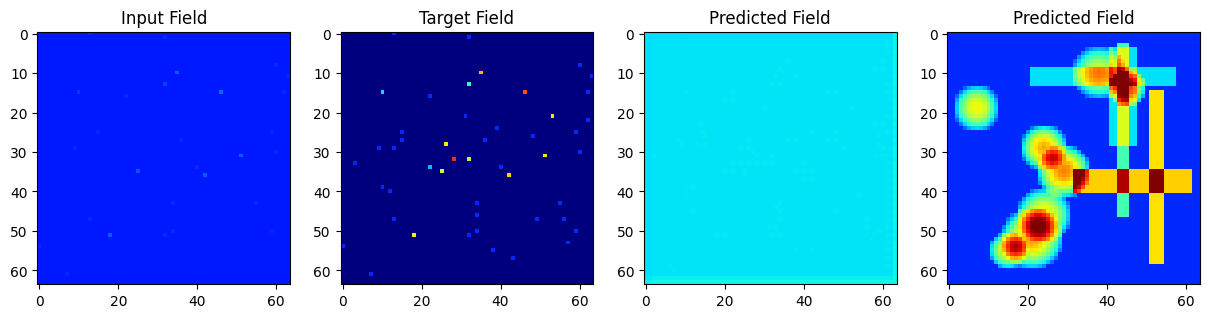

(64, 64) torch.Size([1, 64, 64])
[0.         0.         0.         0.03290383 0.         0.01489973
 0.01037072 0.03937191 0.         0.         0.         0.
 0.         0.         0.         0.03017803 0.         0.02533874
 0.0312668  0.         0.         0.         0.         0.
 0.02941448 0.         0.         0.        ] tensor([0.0000, 0.0000, 0.0000, 0.3290, 0.0000, 0.1490, 0.1037, 0.3937, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3018, 0.0000, 0.2534,
        0.3127, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2941, 0.0000, 0.0000,
        0.0000])


In [69]:
# Create UNet model and loader
from fusion_2d_od.utile_denoising import UNet

ch_in = 2
ch_out = 1
size = 16

# Instanciation :
model = UNet(ch_in, ch_out, size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
gauge_loader = DataLoader(gauge_dataset, batch_size=1, shuffle=True, num_workers=4)
gauges, ground_truth, x, y, proj_x, proj_y = visualize_unet_output(model, gauge_loader)

In [50]:
np.min(proj_y)

-0.1

In [84]:
torch.numel(proj_x[0,1][proj_x[0,1] >= 0])

42

In [83]:
(proj_y[0] >= 0).sum()

tensor(59, device='cuda:0')

In [89]:


# Training loop
gauge_loader = DataLoader(gauge_dataset, batch_size=16, shuffle=True, num_workers=2)
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    count = 0

    for batch in gauge_loader:
        gauges, _ = batch
        gauges = gauges.to(device)
        x, y = part_gauges(gauges)
        proj_x, proj_y = project_to_grid(x, y)
        proj_x[:,1] /= 10.
        optimizer.zero_grad()
        pred = model(proj_x)
        loss = masked_mae_loss(pred, proj_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch + 1}, MAE: {total_loss / count:.4f}")

Epoch 1, MAE: 0.0400
Epoch 2, MAE: 0.0393
Epoch 3, MAE: 0.0394
Epoch 4, MAE: 0.0391
Epoch 5, MAE: 0.0391
Epoch 6, MAE: 0.0390
Epoch 7, MAE: 0.0383


KeyboardInterrupt: 

In [97]:
proj_y

array([[-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       ...,
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, ..., -0.1, -0.1, -0.1]], dtype=float32)

In [99]:
proj_y.max()

0.52914274

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


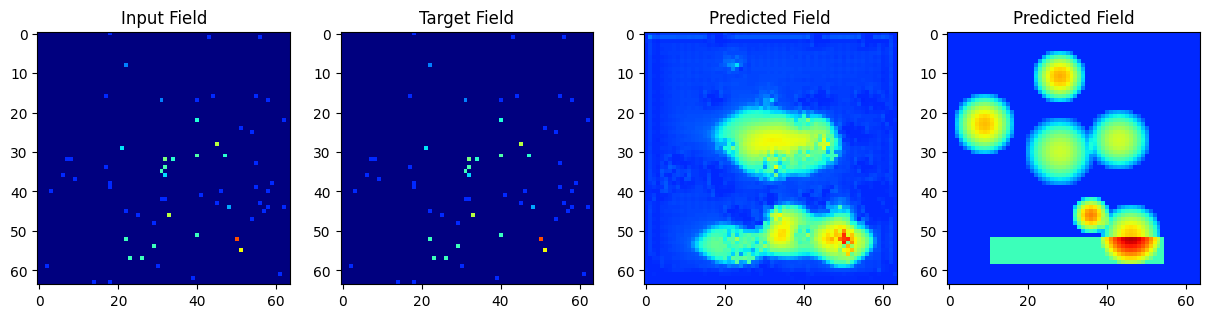

(64, 64) torch.Size([32, 64, 64])
[0.         0.         0.         0.00509933 0.         0.
 0.         0.00509933 0.         0.         0.01336501 0.
 0.         0.         0.0243344  0.01106308 0.0167693  0.01412152
 0.         0.         0.01985494 0.0139937  0.         0.
 0.0163382  0.01575208 0.         0.01047696 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00748553
 0.         0.         0.         0.         0.         0.02429227
 0.         0.         0.0152766  0.0155041  0.03948836 0.0155041
 0.02848921 0.0155041  0.0155041  0.         0.         0.
 0.         0.         0.        ] tensor([0.0000, 0.0000, 0.0000, 0.0510, 0.0000, 0.0000, 0.0000, 0.0510, 0.0000,
        0.0000, 0.1337, 0.0000, 0.0000, 0.0000, 0.2433, 0.1106, 0.1677, 0.1412,
        0.0000, 0.0000, 0.1985, 0.1399, 0.0000, 0.0000, 0.1634, 0.1575, 0.0000,
        0.1048, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [100]:
model.eval()

with torch.no_grad():
    for batch in gauge_loader:
        gauges, ground_truth = batch

        gauges = gauges.to(device)
        x, y = part_gauges(gauges, eval=True)
        x, y = x.to(device), y.to(device)

        proj_x, proj_y = project_to_grid(x, y)

        proj_x[:,1] /= 10.
        pred = model(proj_x)

        # Convert to numpy for visualization
        proj_x = proj_x.cpu().numpy()[0, 1]  # Input values
        proj_y = proj_y.cpu().numpy()[0, 0]  # Target values
        pred = pred.cpu().numpy()[0, 0]  # Predictions

        # Plot results
        fig, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(proj_x, cmap='jet', vmin=-0.01, vmax = 0.05)
        ax[0].set_title("Input Field")
        ax[1].imshow(proj_y, cmap='jet', vmin=-0.1, vmax = 0.5)
        ax[1].set_title("Target Field")
        ax[2].imshow(pred, cmap='jet', vmin=-0.1, vmax = 0.5)
        ax[2].set_title("Predicted Field")
        ax[3].imshow(ground_truth.cpu().numpy()[0], cmap='jet', vmin=-0.1, vmax = 0.5)
        ax[3].set_title("Predicted Field")
        plt.show()
        print(proj_x.shape, ground_truth.shape)
        print(proj_x[proj_x>= 0], ground_truth[0][proj_x>= 0] )
        break  # Visualize only one batch

In [94]:
proj_x.shape

torch.Size([32, 2, 64, 64])

In [ ]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
pluviometres_spatialises =  -0.1 * torch.ones(radar.shape)
pluviometres_spatialises = set_tensor_values(pluviometres_spatialises, pluviometres, 64)
input = torch.cat([radar, pluviometres_spatialises, cmls_spatialises], dim = 1)
print(input.shape)

torch.Size([6, 3, 64, 64])


**Questions intéressantes** : \\
Pourquoi est-ce qu'on créé une matrice de -0.1 pour les pluviomètres spatialisés ? \\
Comment instancier un UNet pour prendre ce type d'input en entrée ? \\
Visualiser les sorties au bout de cinquante époques (100 batches de 32 par époque).

## C. Encodage des différentes variables qui vont alimenter le transformer

In [ ]:
import torch
import torch.nn as nn

class UnifiedEmbedding(nn.Module):
    def __init__(self, d_model, patch_size, channels):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.channels = channels
        self.dim_modality = 4
        # Positional embedding for coordinates
        self.coord_embed = nn.Linear(2, d_model // 3)

        # Modality specific embeddings
        self.patch_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.point_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.segment_modality = nn.Parameter(torch.randn(self.dim_modality))

        # Feature embedding for radar image patches
        self.patch_feature_embed = nn.Conv2d(channels, d_model - self.dim_modality \
                - 2 * (d_model // 3), kernel_size=patch_size, stride=patch_size)

        # Feature embedding for point and segment rain rates
        self.punctual_rain_rate_embed = nn.Linear(1, d_model - self.dim_modality \
                                                  - 2 * (d_model // 3))
        self.integrated_rain_rate_embed = nn.Linear(1, d_model - self.dim_modality \
                                                    - 2 * (d_model // 3))

    def forward(self, image, points, segments):
        B, C, H, W = image.shape
        device = image.device
        # print("Image shape:", image.shape)

        # Embedding patches
        patch_embeddings = self.patch_feature_embed(image).flatten(2).transpose(1, 2)
        # print("Patch embeddings shape:", patch_embeddings.shape)

        # Create grid for patches
        grid_x, grid_y = torch.meshgrid(torch.arange(0, H, self.patch_size), torch.arange(0, W, self.patch_size), indexing='ij')
        grid_x = grid_x.to(device)  # Move to device
        grid_y = grid_y.to(device)  # Move to device
        upleft = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1).float()
        downright = torch.stack((grid_x.flatten() + self.patch_size, grid_y.flatten() + self.patch_size), dim=-1).float()
        # erreur chatGPT !! patch_pos_embeddings = self.coord_embed(upleft) + self.coord_embed(downright)
        patch_pos_embeddings = torch.cat([self.coord_embed(upleft), self.coord_embed(downright)], dim=-1)
        patch_pos_embeddings = patch_pos_embeddings.repeat(B, 1, 1)
        # print("Patch positional embeddings shape:", patch_pos_embeddings.shape)

        patch_embeddings = torch.cat([patch_embeddings, patch_pos_embeddings, self.patch_modality.unsqueeze(0).expand(B, patch_embeddings.size(1), -1)], dim=-1)
        # print("Final patch embeddings shape:", patch_embeddings.shape)

        # Embedding points
        point_pos_embeddings = self.coord_embed(points[..., :2].float())
        # print("Point positional embeddings shape:", point_pos_embeddings.shape)

        point_feature_embeddings = self.punctual_rain_rate_embed(points[..., 2:].float())
        point_embeddings = torch.cat([point_feature_embeddings, point_pos_embeddings, point_pos_embeddings, self.point_modality.unsqueeze(0).expand(B, points.size(1), -1)], dim=-1)
        # print("Final point embeddings shape:", point_embeddings.shape)

        # Embedding segments
        seg_pos_embeddings0 = self.coord_embed(segments[..., :2].float())
        seg_pos_embeddings1 = self.coord_embed(segments[..., 2:4].float())
        segment_feature_embeddings = self.integrated_rain_rate_embed(segments[..., 4:].float())
        segment_embeddings = torch.cat([segment_feature_embeddings, seg_pos_embeddings0, seg_pos_embeddings1, self.segment_modality.unsqueeze(0).expand(B, segments.size(1), -1)], dim=-1)
        # print("Final segment embeddings shape:", segment_embeddings.shape)

        # Concatenate all embeddings
        embeddings = torch.cat([patch_embeddings, point_embeddings, segment_embeddings], dim=1)


        return embeddings



class Attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        # Nombre de "têtes"
        self.heads = n_heads

        # Taille des vecteurs requête, clefs, valeur
        self.head_dim = d_model // n_heads

        # Scalaire utilisé à l'étape de normalisation
        self.scale = self.head_dim ** -0.5

        # Première application linéaire
        self.qkv = nn.Linear(d_model, n_heads * self.head_dim * 3)

        # Seconde application linéaire
        self.proj = nn.Linear(n_heads * self.head_dim, d_model)


    def forward(self, x, mask=None):
        B, N, C = x.shape

        # Calcul des requêtes, clefs, valeurs
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )
        # Produits scalaires
        p = (q @ k.transpose(-2, -1))

        # A décommenter pour la question 10:
        # print(q.shape, k.transpose(-2, -1).shape)

        # Etape de normalisation
        p *= self.scale
        p = p.softmax(dim=-1)

        # Somme pondérée
        x = (p @ v).transpose(1, 2).reshape(B, N, C)

        # Sortie
        x = self.proj(x)

        return x

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)

    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

# ou avec dropout
import torch.nn.init as init
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        init.normal_(self.fc1.weight, std=0.02)  # Example initialization
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)
        init.normal_(self.fc2.weight, std=0.02)  # Example initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc2(x)
        return x

class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)


    def forward(self, x, mask=None, return_attention=False):
        #a modifier (voir question 14)
        y = self.attn(self.norm1(x), mask)
        y = self.mlp(self.norm2(y))
        return y


class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)

    def forward(self, x, mask=None, return_attention=False):
        x_attn = self.norm1(x)
        if return_attention:
            y, attn_weights = self.attn(x_attn, mask, return_attention=True)
        else:
            y = self.attn(x_attn, mask)
        # Applying skip connection around the attention layer
        y = x + y

        x_mlp = self.norm2(y)
        y = self.mlp(x_mlp)
        # Applying skip connection around the MLP layer
        y = y + x_mlp

        if return_attention:
            return y, attn_weights
        return y


from einops import rearrange



def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def trunc_normal_(tensor, mean=0, std=1):
    nn.init.trunc_normal_(tensor, mean=mean, std=std)


class Up0(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up0, self).__init__()  # Corrected super call
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class Decoder(nn.Module):
    """
    vaut uniquement si channels = 1 et image_size =64
    """
    def __init__(self, patch_size, d_model):
        super().__init__()

        self.d_model = d_model
        self.ps = patch_size
        self.up =  Up0(d_model, 32)
        self.up2 =  Up0(32, 16)
        # self.up3 =  Up0(8, 4)
        self.outc = outconv(16, 5)

    def forward(self, x):

        x = rearrange(x, "b (h w) c -> b c h w", h=64 // self.ps)
        x = self.up(x)
        x = self.up2(x)
        # x = self.up2(x)
        # x = self.up3(x)
        x = self.outc(x)
        return x


# class Decoder(nn.Module):
#     """
#     vaut uniquement si channels = 1 et image_size =64
#     """
#     def __init__(self, patch_size, d_model):
#         super().__init__()

#         self.d_model = d_model
#         self.ps = patch_size
#         self.up =  Up0(d_model, 8)
#         # self.up2 =  Up0(16, 8)
#         # self.up3 =  Up0(8, 4)
#         self.outc = outconv(8, 1)

#     def forward(self, x):
#         x = rearrange(x, "b (h w) c -> b c h w", h=64 // self.ps)
#         x = self.up(x)
#         # x = self.up2(x)
#         # x = self.up2(x)
#         # x = self.up3(x)
#         x = self.outc(x)
#         return x

class FusionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
    ):
        super().__init__()
        self.ue = UnifiedEmbedding(d_model, patch_size, channels)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads


        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for _ in range(n_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

        self.apply(init_weights)

        self.decoder = Decoder(patch_size, d_model)

        self.p = torch.nn.Parameter(torch.ones(16))

    def forward(self, x, y, z):
        # Embed signal
        x = self.ue(x, y, z)  # (B, N, D)

        # Process through each transformer block
        for block in self.blocks:
            x = block(x)

        # Apply final normalization
        x = self.norm(x)
        x = x[:,:256,:]

        x = self.decoder(x)

        return x




In [ ]:
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 6
n_layers = 12

In [ ]:
# Module interne du réseau responsable de l'encodage des variables :
from PREAC.utile_Transformers import UnifiedEmbedding
ue = UnifiedEmbedding(d_model, patch_size, channels)


In [ ]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
embeddings = ue(radar, pluviometres, cmls)
print(embeddings.shape)

torch.Size([6, 288, 120])


In [ ]:
# Probleme plus complexe:

pip install einops
from fusion_2d_od.utile_Transformers import voir_batch2D, gen_image_with_pairs, set_tensor_values

# Notre jeu de données contient:
# une cible parfaite (lamedeau)
# des triplets "pluviometres" :
# (lon_pluvio, lat_pluvio, taux de pluie mesuré)
# des quintuplets "cmls" associés aux antennes A & B:
# (lon_A, lat_A, lat_B, lon_B, taux de pluie moyen entre A et B)

batch_size = 6
n_pairs = 16
n_points = 16
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
cmls_spatialises = set_tensor_values(cmls_spatialises, pluviometres, 64)
radar[cmls_spatialises > 0] = cmls_spatialises[cmls_spatialises > 0 ]
voir_batch2D(radar, 6, fig4, k=0, min_scale=0., max_scale=1.2)


## D. Entraînement du Transformer

In [ ]:
# from PREAC.utile_Transformers import FusionTransformer
torch.manual_seed(0)
model = FusionTransformer(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
# model(radar, pluviometres, cmls).shape

In [ ]:
def criterion(output, target):
    return torch.abs((output - target)).mean()

import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), 10**(-4))
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, total_iters=40)
# scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=0.00001)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[20])

In [ ]:
import torch
bce = torch.nn.BCELoss()
# bce = torch.nn.BCELoss(reduction='none')
m = torch.nn.Sigmoid()

l1 = torch.nn.L1Loss()
l2 = torch.nn.MSELoss()

In [ ]:
def f1(x, y, alpha = 100.):
  loss = bce(x, y)
  alphat = torch.full_like(y, 1)
  alphat[y==1] = alpha
  loss *= alphat
  return loss.mean()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def create_conic_kernel(size=17, ray=8):
    """
    Create a 2D conic kernel using the given size and ray.
    The kernel's maximum value is 1 at the center and decreases linearly to 0 at the edges.
    """
    x_center = size // 2
    y_center = size // 2

    # Create coordinate tensors using meshgrid
    x = torch.arange(size).float()
    y = torch.arange(size).float()
    xx, yy = torch.meshgrid(x, y, indexing='ij')

    # Calculate the conic kernel
    distances = ((ray**2 - (xx - x_center)**2 - (yy - y_center)**2).clamp(min=0))
    kernel = distances / ray
    return kernel

In [ ]:
def smooth(tensor, kernel):
    """
    Smooth the input 4D tensor (B, C, H, W) by applying the given kernel along the C dimension.
    :param tensor: 4D torch tensor of shape (B, C, H, W)
    :param kernel: 2D torch tensor (the conic kernel)
    :return: Smoothed tensor of the same shape as the input
    """
    B, C, H, W = tensor.shape

    # Ensure kernel is 2D
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, K, K)

    # Calculate padding size
    pad_size = kernel.size(-1) // 2

    # Reshape input tensor to merge batch and channel dimensions
    input_tensor = tensor.view(B * C, 1, H, W)  # Shape: (B*C, 1, H, W)

    # Apply padding to both height and width dimensions
    padded_tensor = F.pad(input_tensor, (pad_size, pad_size, pad_size, pad_size), mode='constant', value=0)

    # Perform convolution without groups
    smoothed = F.conv2d(padded_tensor, kernel)  # No need for groups

    # Reshape back to the original dimensions
    smoothed = smoothed.view(B, C, H, W)

    return smoothed



In [ ]:
pluviometres_spatialises.shape

torch.Size([6, 1, 64, 64])

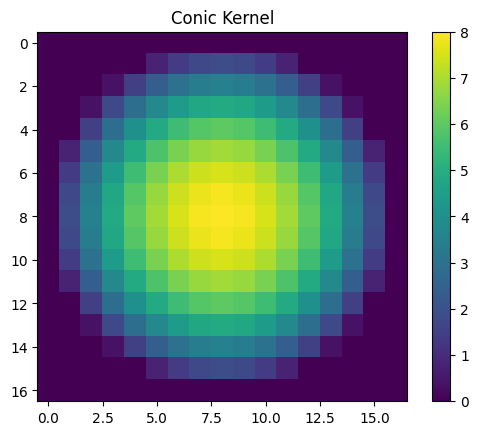

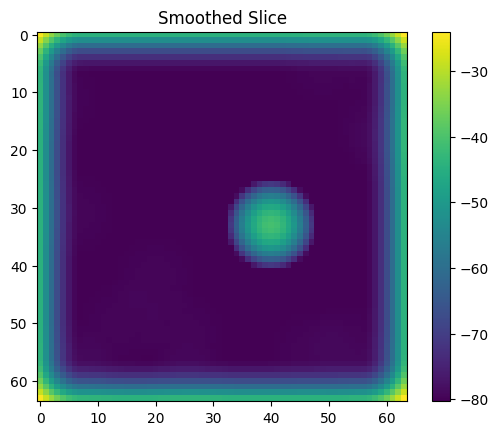

In [ ]:
kernel = create_conic_kernel(size=17, ray=8)

# Visualize the kernel
plt.imshow(kernel, cmap="viridis")
plt.colorbar()
plt.title("Conic Kernel")
plt.show()

# Create a dummy input tensor
B, C, H, W = 1, 60, 64, 64
input_tensor = torch.zeros((B, C, H, W))
input_tensor[:, :, 32, 32] = 1  # Activate a single pixel in each channel

# Smooth the input tensor
smoothed_tensor = smooth(pluviometres_spatialises.cpu(), kernel)

# Visualize one smoothed slice
plt.imshow(smoothed_tensor[0, 0].detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Smoothed Slice")
plt.show()

In [ ]:
nepochs = 500
nbatches = 100
batchsize = 64
train_losses = []
device = torch.device('cuda:0')
model = model.to(device)
kernel = kernel.cuda()
iters = nbatches

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []

    for i in range(nbatches):
        lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(batchsize, n_pairs, n_points)
        lamedeau, pluviometres, radar, cmls_spatialises, cmls = lamedeau.cuda(), pluviometres.cuda(), radar.cuda(), cmls_spatialises.cuda(), cmls.cuda()
        pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
        pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)

        optimizer.zero_grad()
        outputs = model(radar, pluviometres, cmls)
        smoothed_pluviometres = smooth(pluviometres_spatialises, kernel)

        loss1 = bce(m(outputs[:,[1]]), (cmls_spatialises > 0).float())
        loss2 = l1(outputs[:,[2]][cmls_spatialises>0], cmls_spatialises[cmls_spatialises>0])
        loss3 = bce(m(outputs[:,[3]]), (smoothed_pluviometres > 0).float())
        loss4 = l1(outputs[:,[4]][smoothed_pluviometres>0], smoothed_pluviometres[smoothed_pluviometres>0])

        loss = 1/(2*model.p[1]**2) * loss1 + 1/(2*model.p[2]**2) * loss2 + 1/(2*model.p[3]**2) * loss3 + 1/(2*model.p[4]**2) * loss4
        loss += torch.log(1 + model.p[1]**2 + model.p[2]**2 + model.p[3]**2 + model.p[4]**2)
        # print(loss1.item(), loss2.item(), loss3.item(), loss4.item())

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().cpu().item())

    scheduler.step()

    print('lr scheduler', scheduler.get_last_lr())

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')


Epoch 1/500
lr scheduler [2.5975e-06]
Epoch loss: 3.0770
Epoch 2/500
lr scheduler [5.095e-06]
Epoch loss: 3.0290
Epoch 3/500
lr scheduler [7.592500000000001e-06]
Epoch loss: 2.9691
Epoch 4/500


KeyboardInterrupt: 

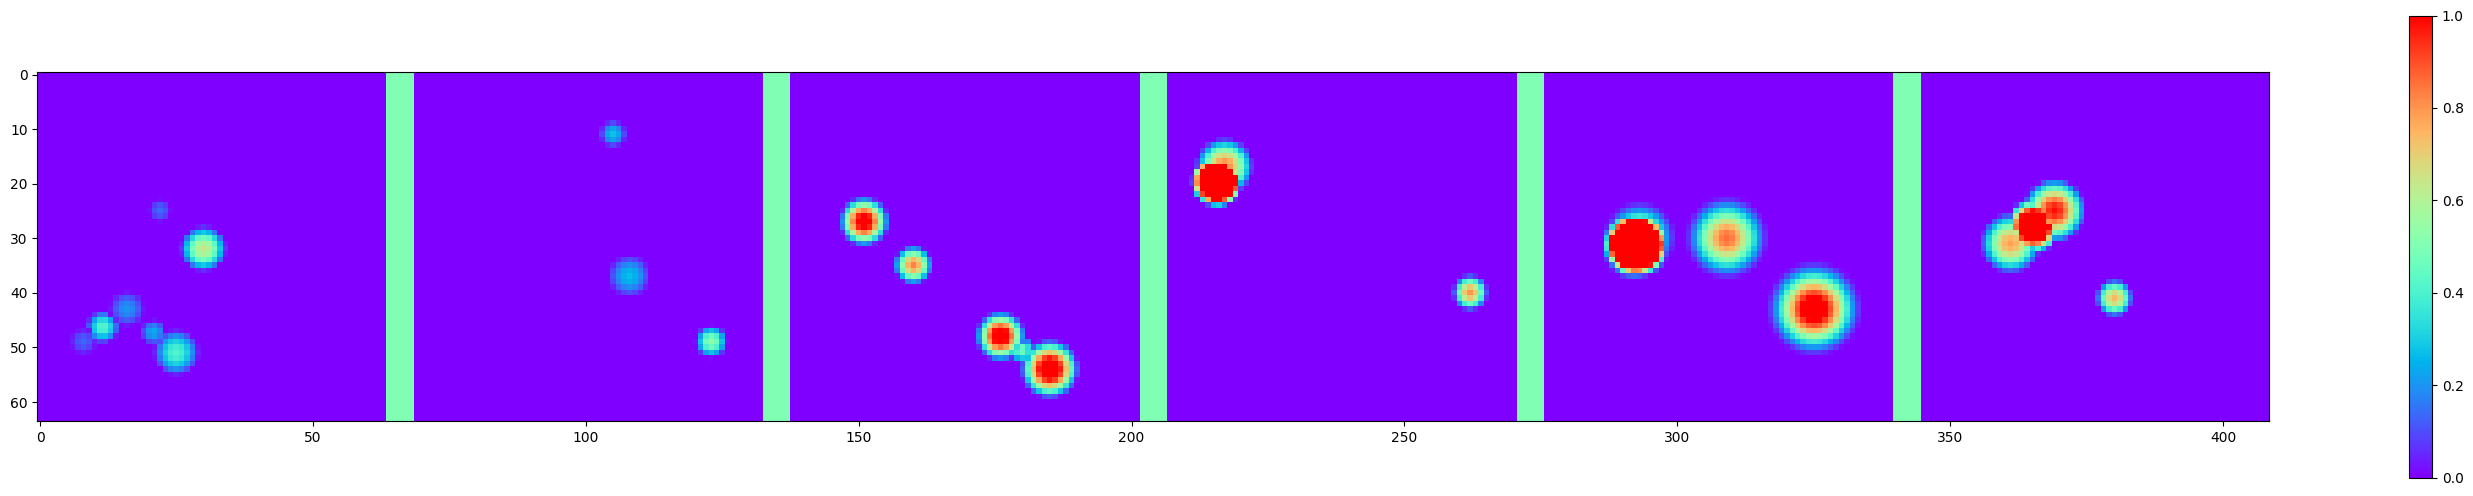

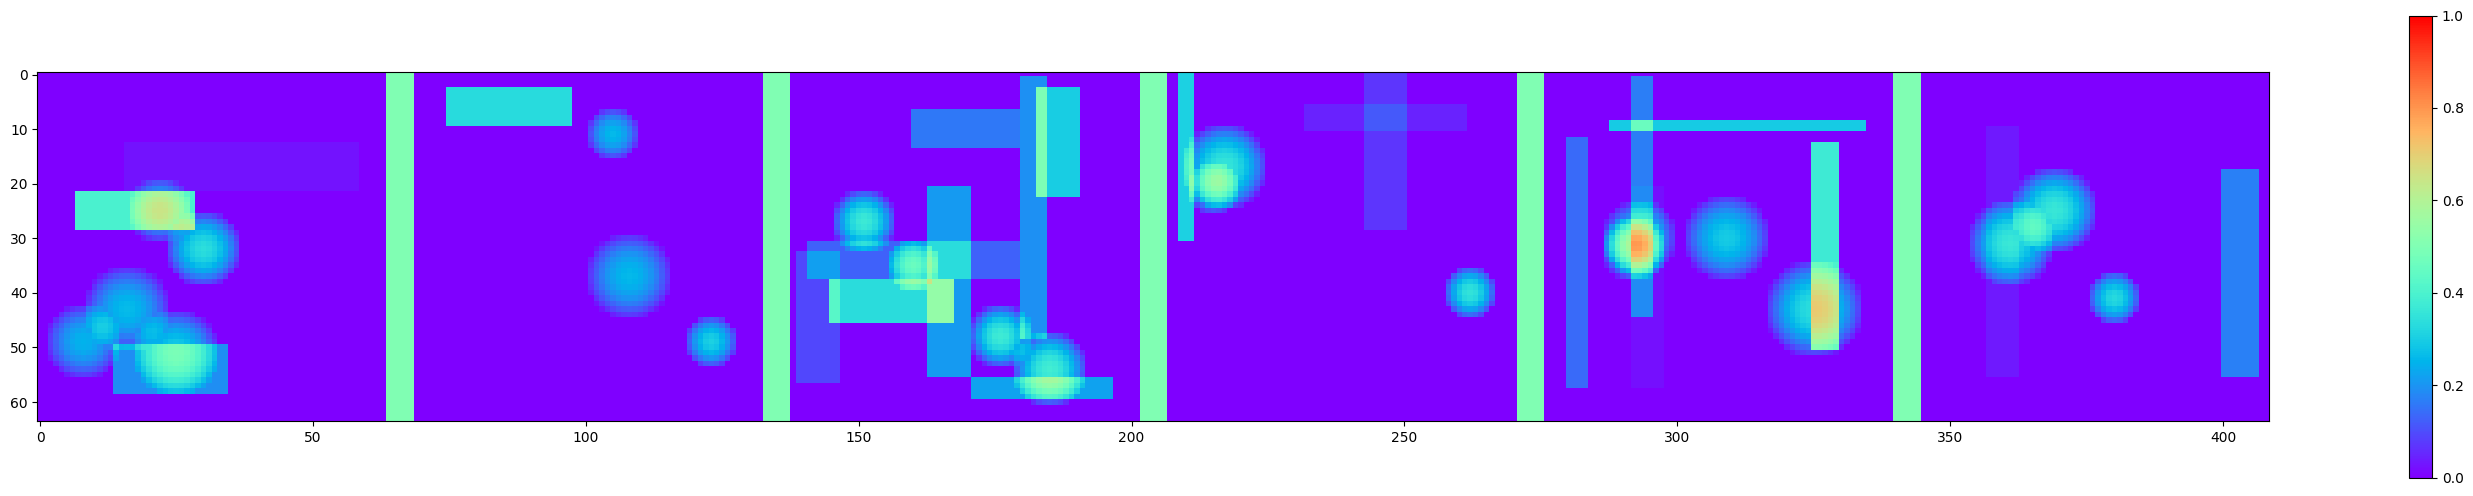

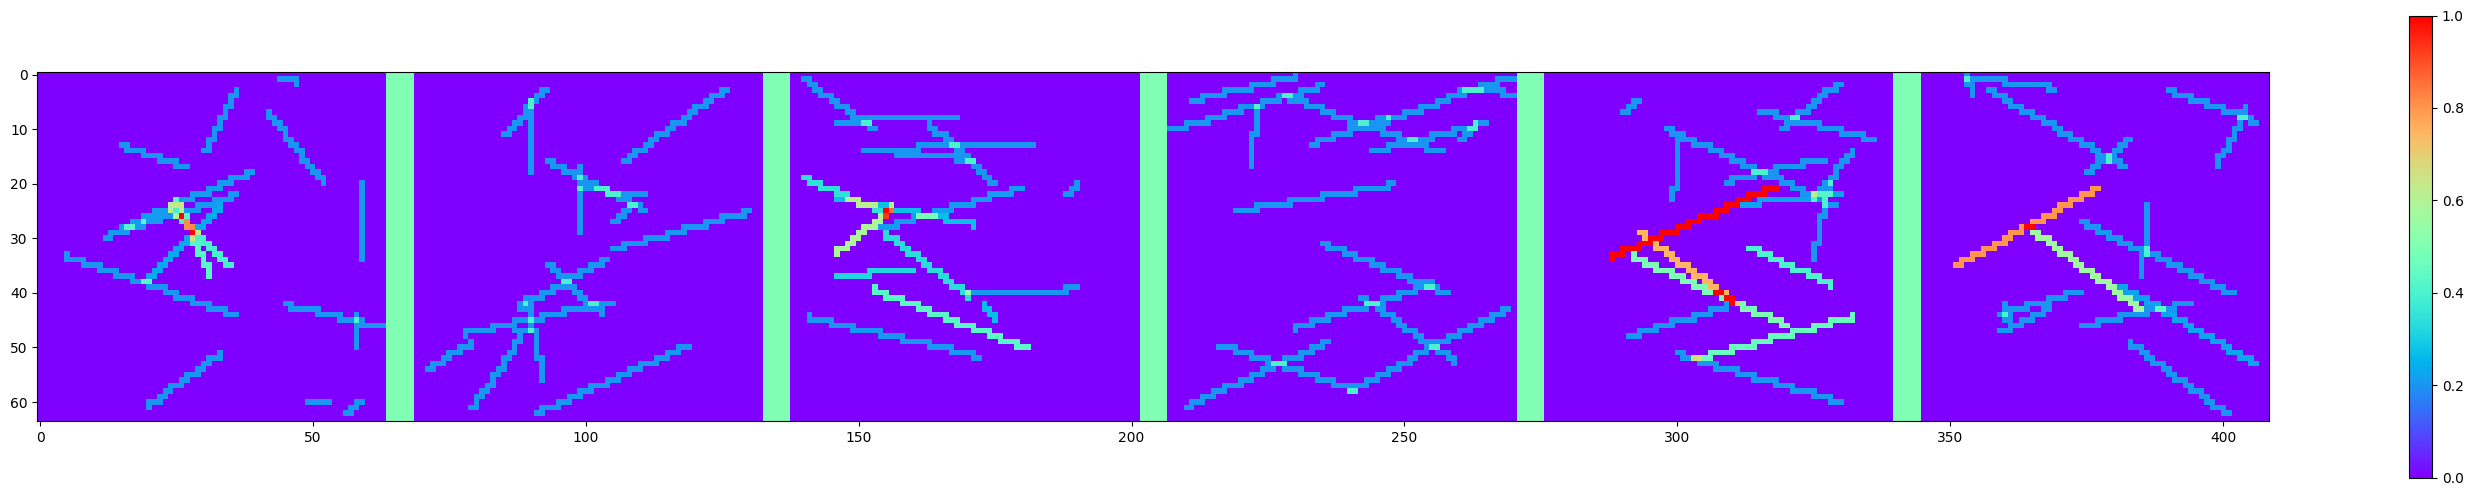

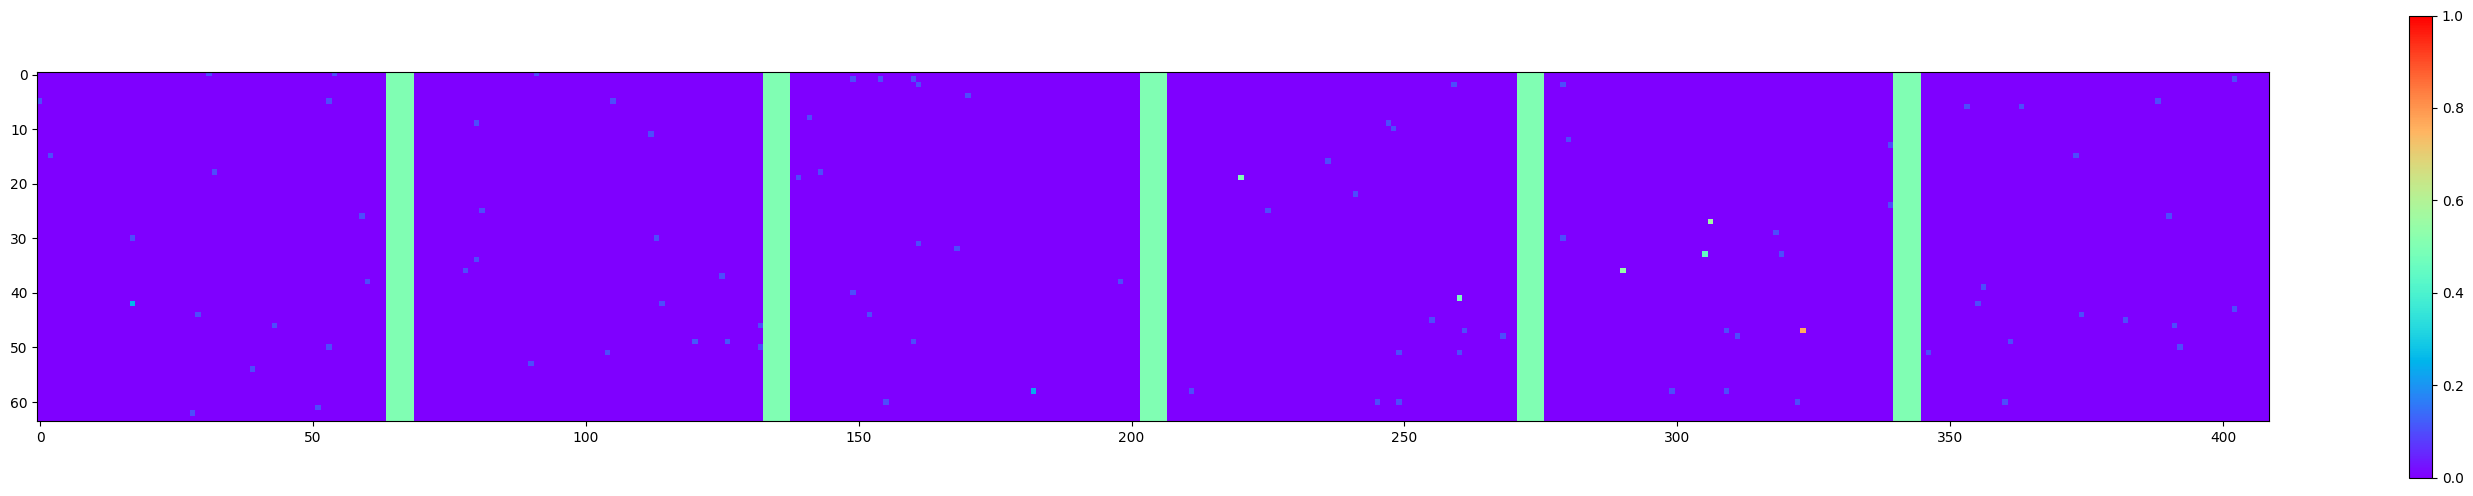

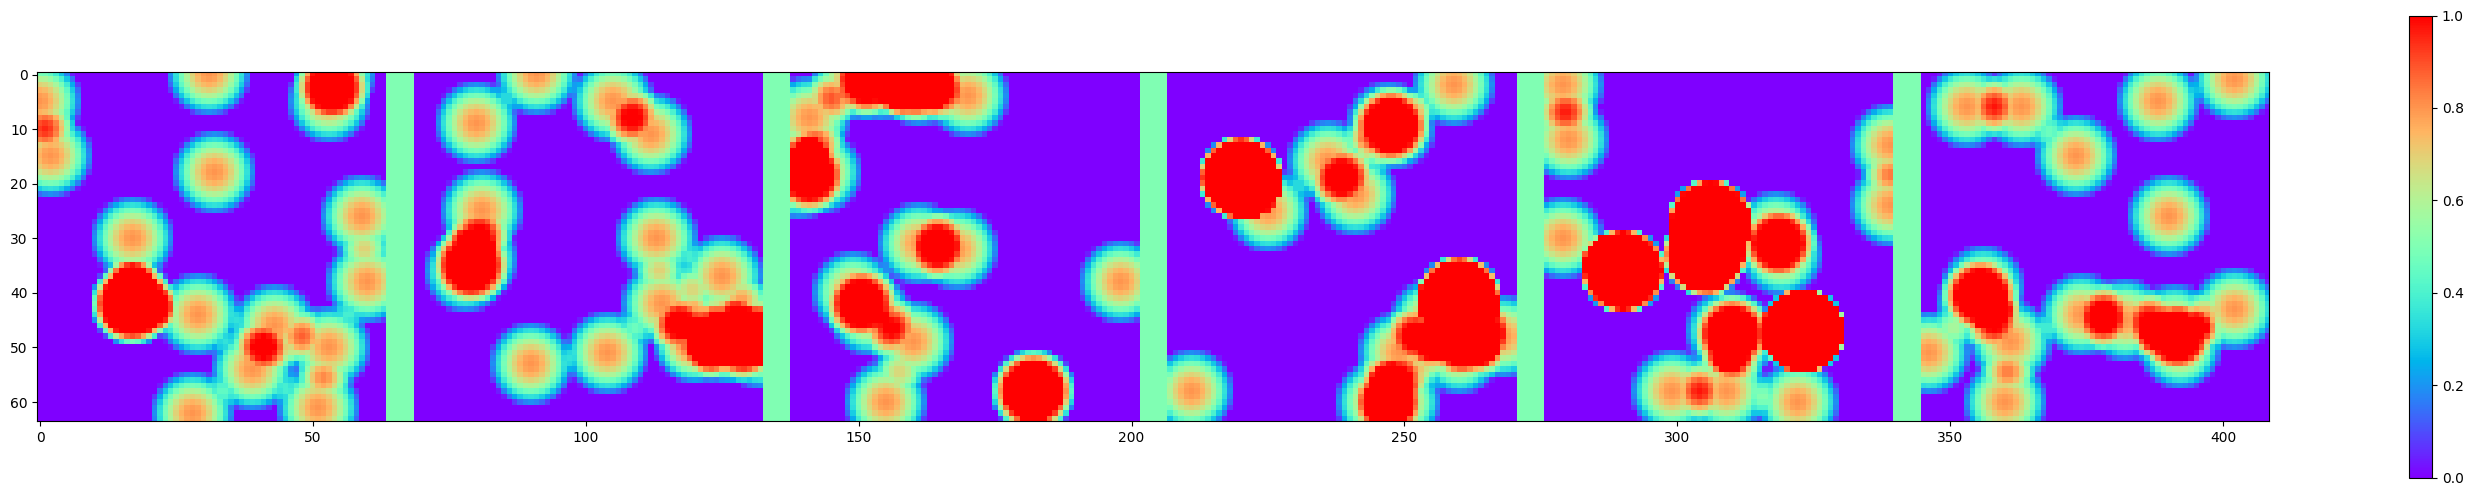

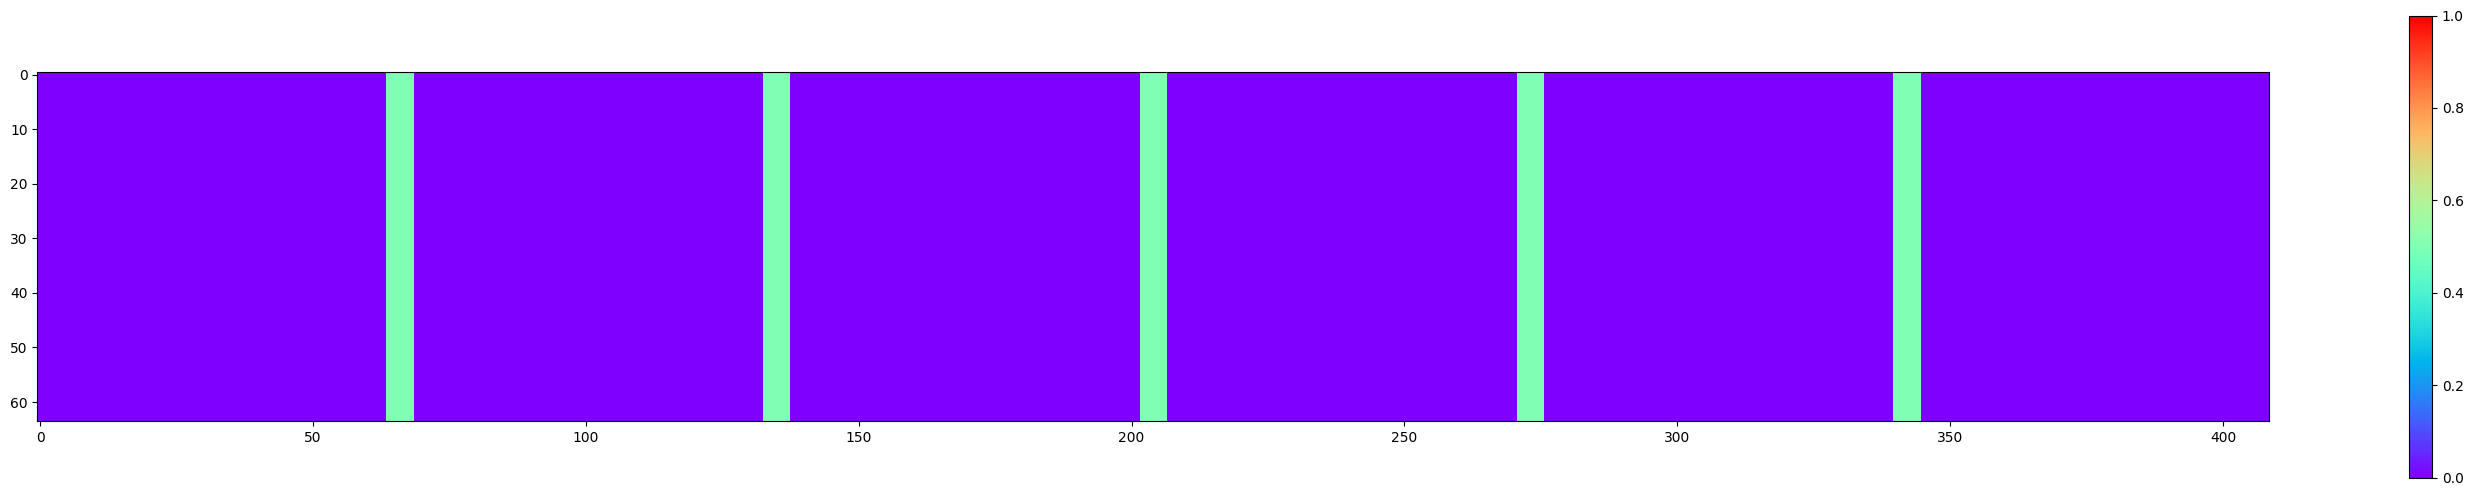

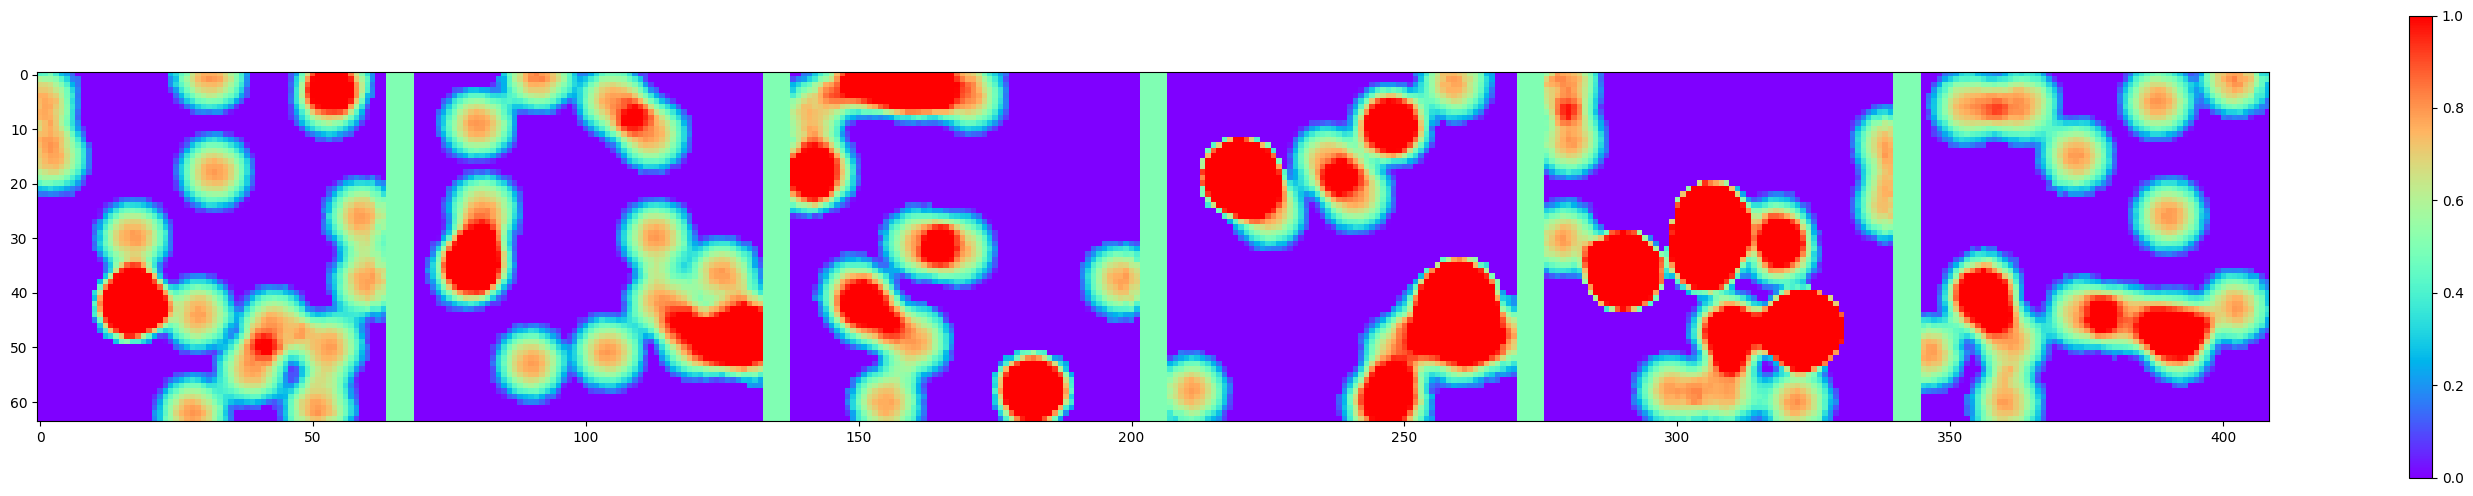

In [ ]:
    #visualization:
# epoque 300 : l'un a convergé mais pas l'autre
model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)


radar = radar.to(device)
cmls = cmls.to(device)
pluviometres = pluviometres.to(device)
pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)
targets = smooth(pluviometres_spatialises, kernel.cpu())
outputs = model(radar, pluviometres, cmls)

radar = radar.cpu()
cmls = cmls.cpu()
pluviometres = pluviometres.cpu()
outputs = outputs.cpu().detach()

# lame d'eau "idéale"
fig0= plt.figure(0, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig0, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(radar, 6, fig1, k=0, min_scale=0, max_scale=1)

# cmls
fig1 = plt.figure(2, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(pluviometres_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(targets.cpu(), 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
voir_batch2D((m(outputs[:,[1]]) > 0.5)*outputs[:,[2]], 6, fig4, k=0, min_scale=0, max_scale=1)


# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig5 = plt.figure(5, figsize=(36, 6))
voir_batch2D((m(outputs[:,[3]]) >0.5)*outputs[:,[4]], 6, fig5, k=0, min_scale=0, max_scale=1)

In [ ]:
targets.shape

torch.Size([64, 1, 64, 64])

**Questions intéressantes** : \\
Quelle différence qualitative entre les outputs ? \\
Que doit faire le transformer "en plus", comparé au FCN ?



## E. Chargement d'un Transformer entraîné

In [ ]:
# Avec France Transfert ??
# !curl 'https://francetransfert.numerique.gouv.fr/api-private/download-module/generate-download-url' -X POST \
# -H 'Content-Type: application/json' \
# -H 'Origin:https://francetransfert.numerique.gouv.fr' \
# --data-raw '{"enclosure":"164ea132-cf5e-4a8d-a084-62841b3122ec","recipient":"cGllcnJlLmxlcGV0aXRAbWV0ZW8uZnI%3D","token":"ddf68980-7b19-4eef-8a34-88a3e32a0f71","senderToken":null,"password":"2q*vbl62!FK@Z"}'

In [ ]:
# Modèles entraînés sur 900 époques :
# mViT_900ep.pth comme au D.
# mViT_0radar_900ep.pth avec, au préalable: radar = 0 x radar
! wget https://www.grosfichiers.com/K3aaxZcSnX4_Fic8rPjJ9yZ
! unzip K3aaxZcSnX4_Fic8rPjJ9yZ
! rm K3aaxZcSnX4_Fic8rPjJ9yZ

In [ ]:
# charger un checkpoint avec torch .load
# visualiser les outputs

checkpoint = torch.load('mViT_900ep.pth')
model.load_state_dict(checkpoint['model_state_dict'])

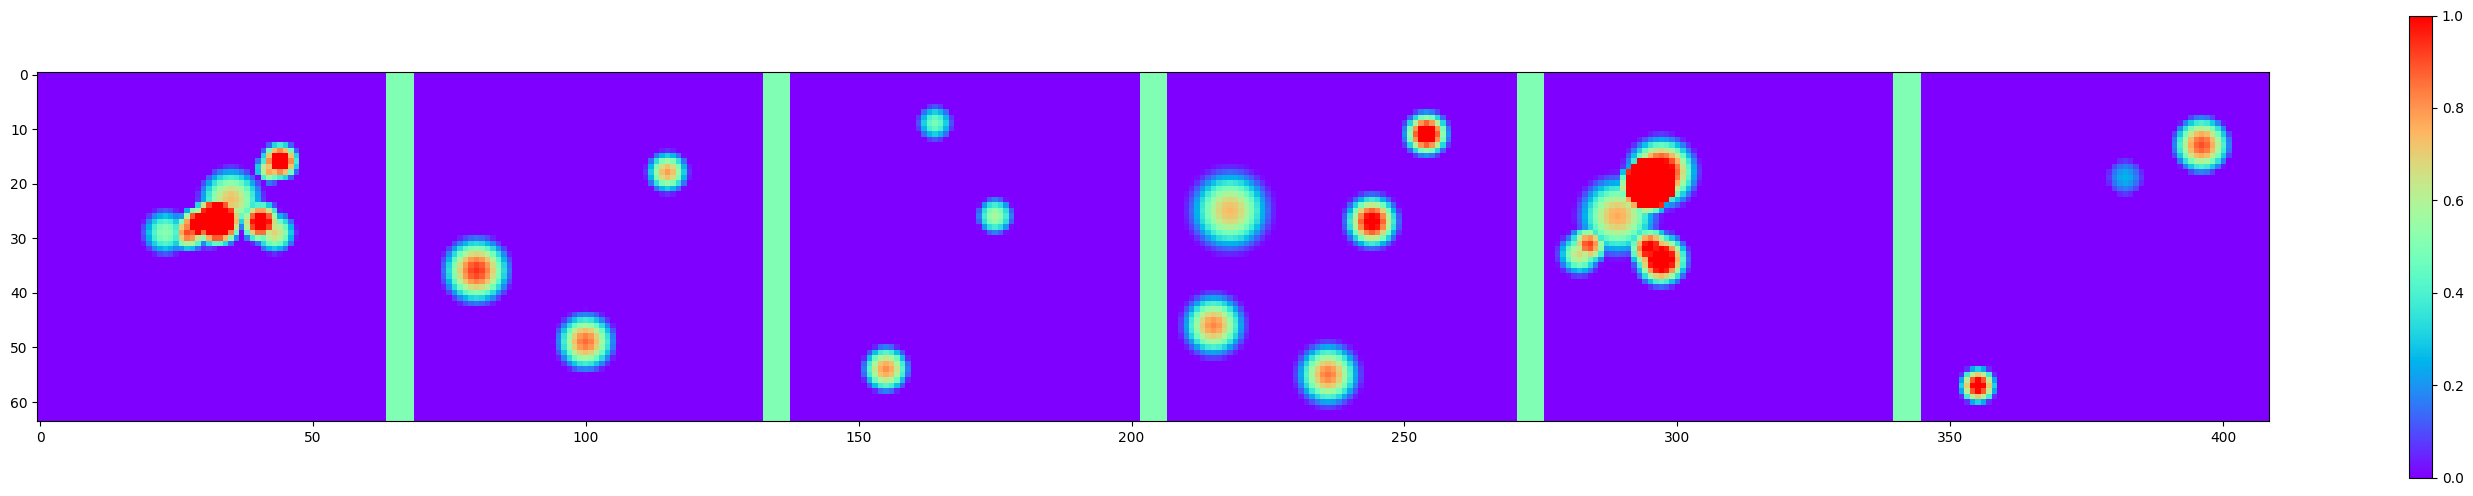

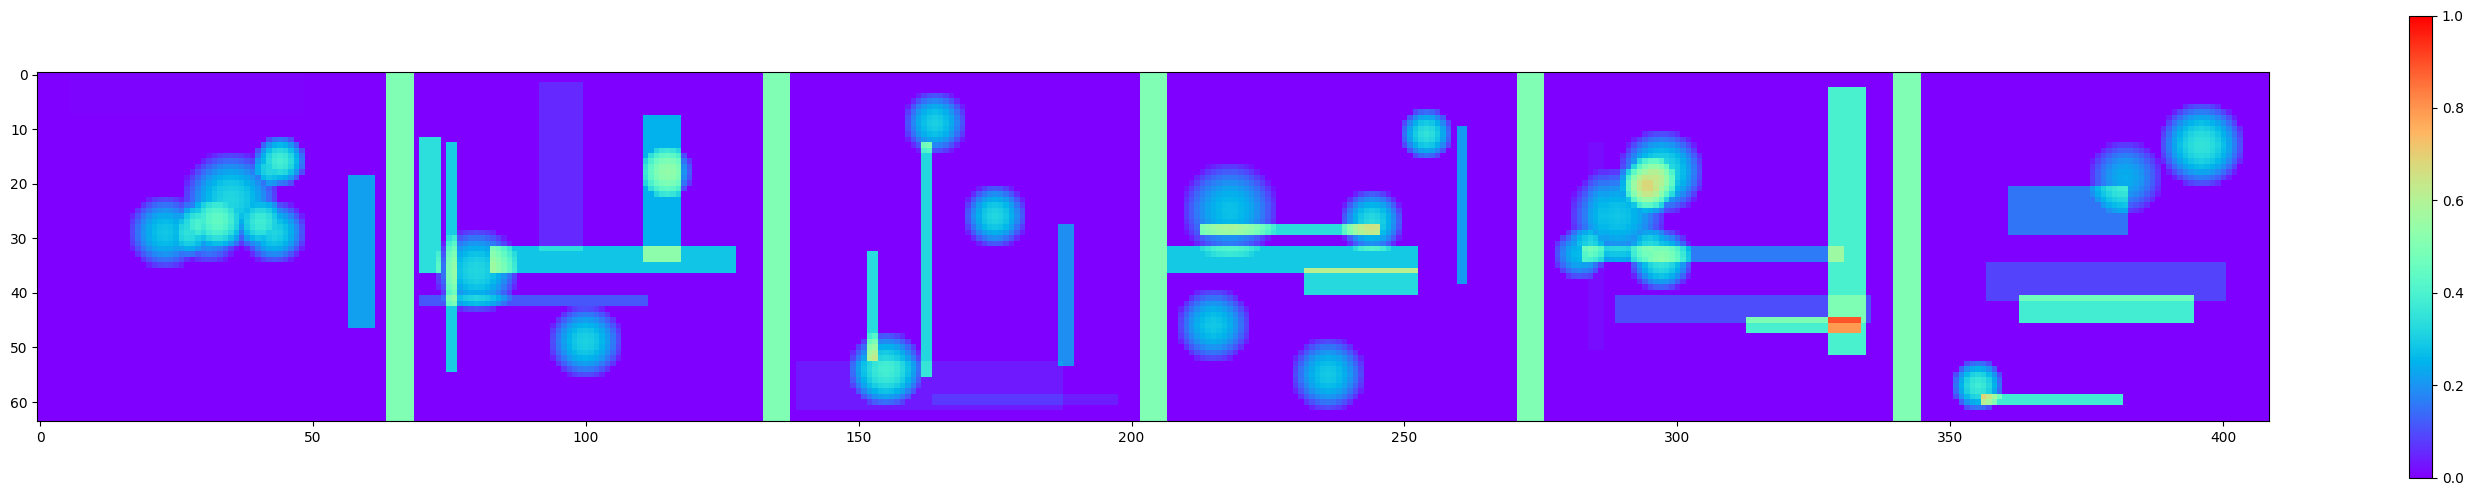

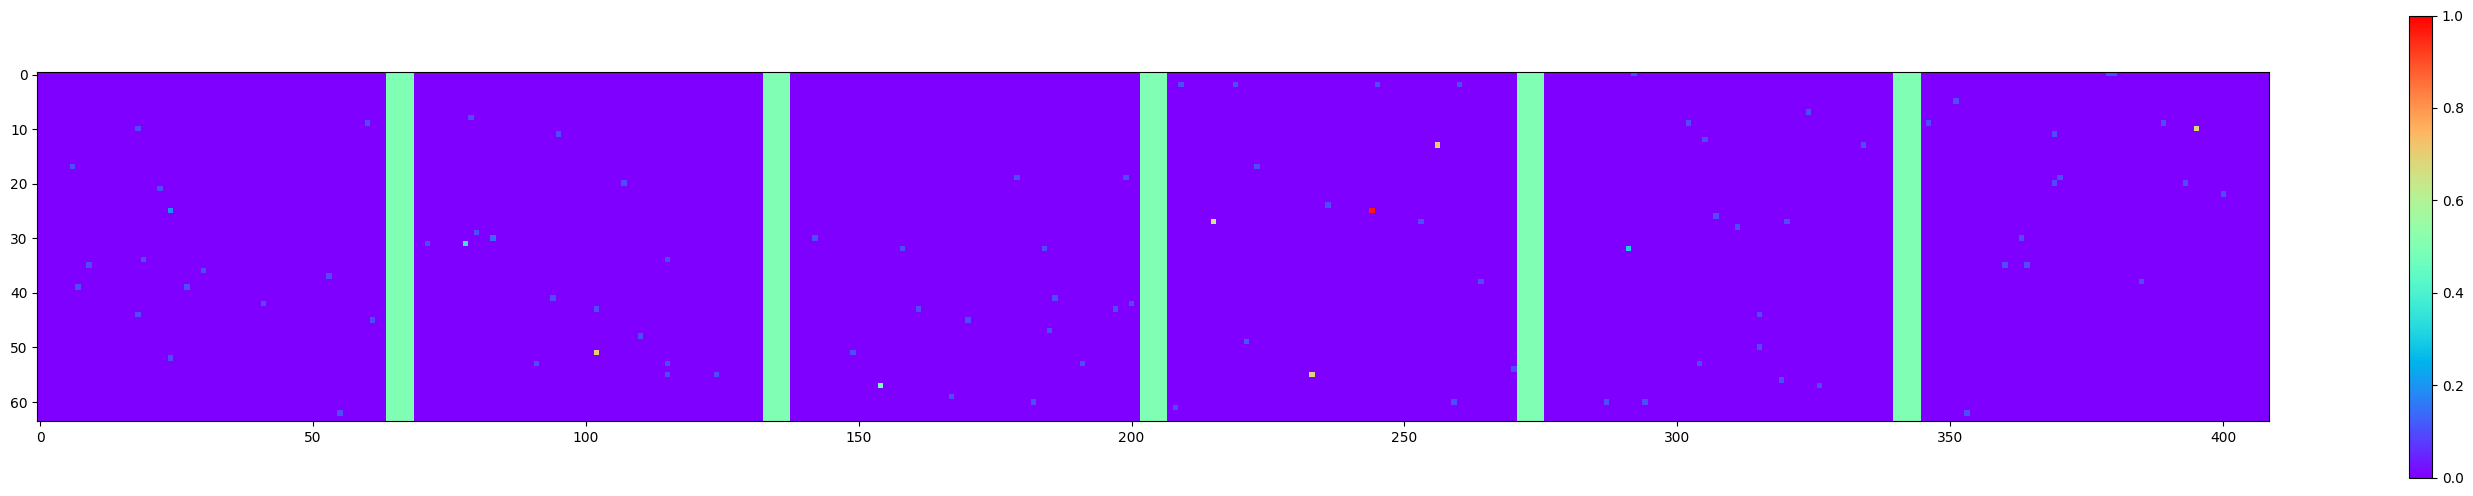

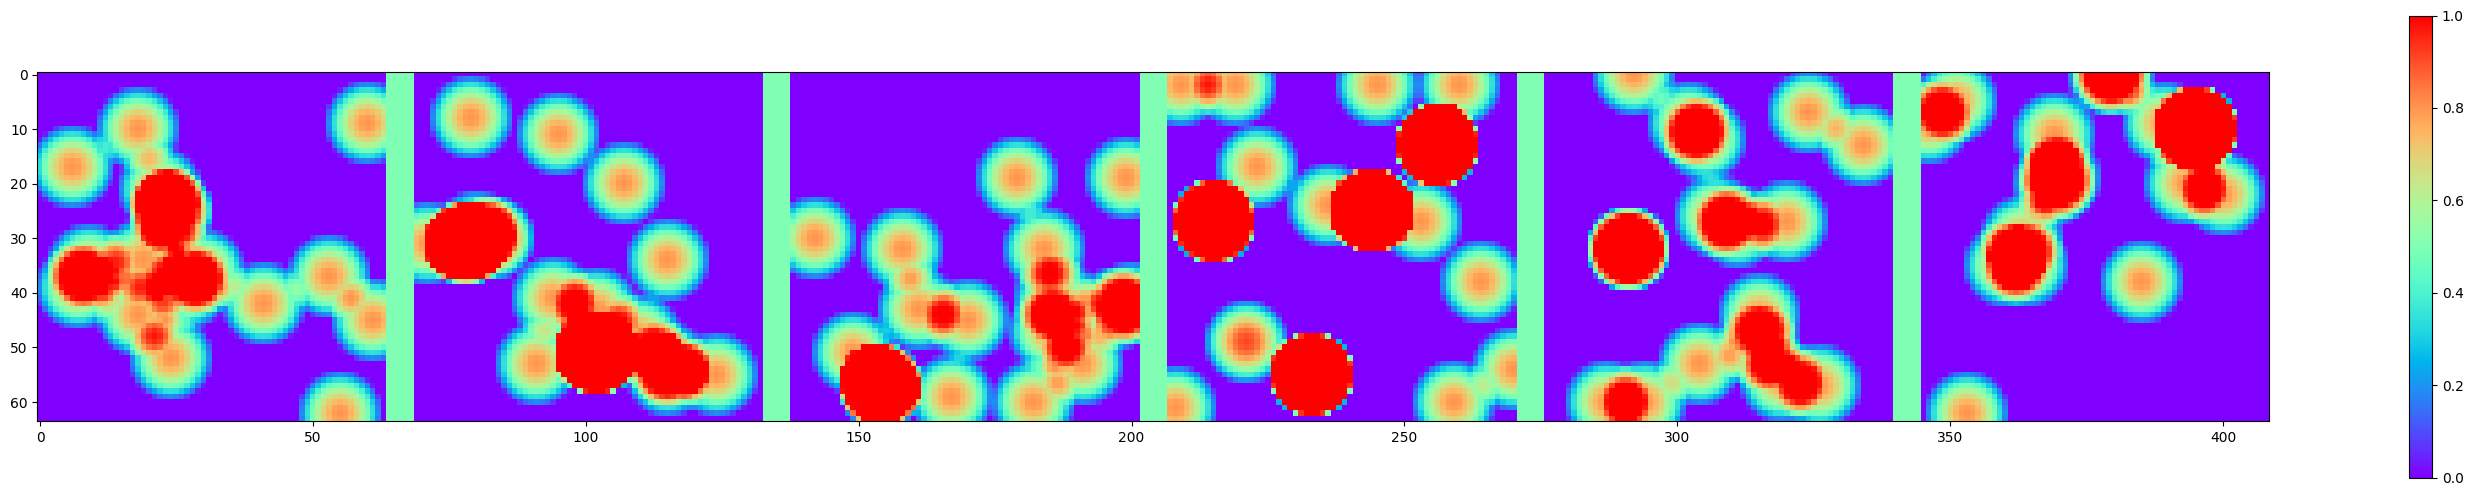

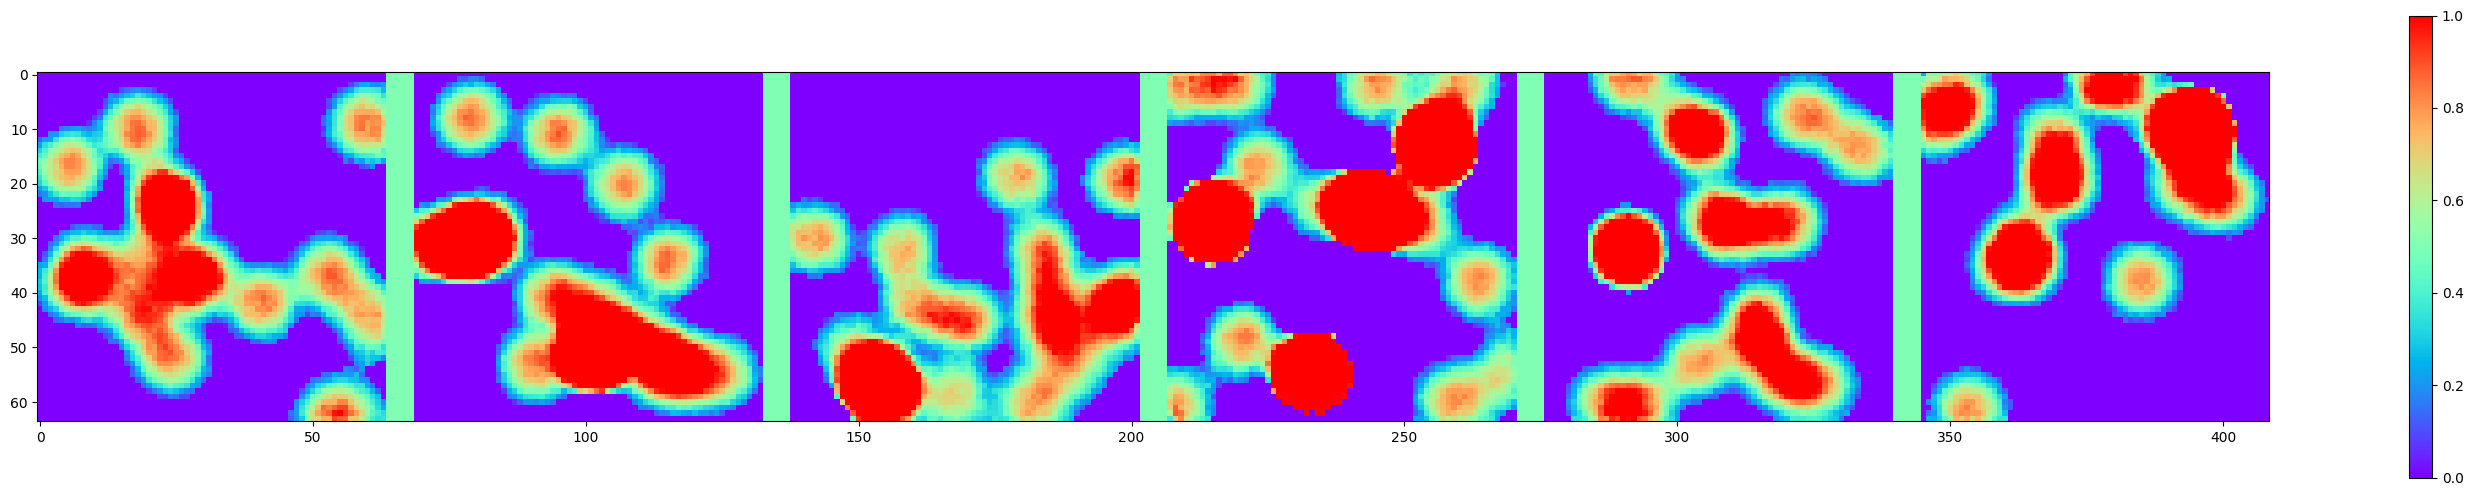

In [ ]:
#visualization:

model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)


radar = radar.to(device)
cmls = cmls.to(device)
pluviometres = pluviometres.to(device)
pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)
targets = smooth(pluviometres_spatialises, kernel.cpu())
outputs = model(radar, pluviometres, cmls)

radar = radar.cpu()
cmls = cmls.cpu()
pluviometres = pluviometres.cpu()
outputs = outputs.cpu().detach()

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(pluviometres_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(targets.cpu(), 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
voir_batch2D((m(outputs[:,[0]]) >0.5)*outputs[:,[1]], 6, fig3, k=0, min_scale=0, max_scale=1)



In [ ]:
torch.median(targets.cpu())

tensor(0.)

**Question intéressante** : \\
Le transformer parvient-il à exploiter les valeurs de pluviomètres et des cmls  ?

Bibliographie :  [Jaegle et al. 2020](https://arxiv.org/abs/1811.12739)